In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x):
    means = np.array([[-3.0, 0.0],
                      [ 3.0, 0.0]])
    cov = np.array([[1.0, 0.5],
                    [0.5, 1.0]])
    comps = rng.integers(0, 2, size=n_samples)
    xs = np.array([rng.multivariate_normal(means[k], cov) for k in comps])
    return xs

In [ ]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x, max_lag=200):

    x = np.asarray(x)
    n = len(x)
    if n < 2:
        return 1.0

    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[n-1:]
    acf /= acf[0]

    m = min(max_lag, len(acf) - 1)

    tau = 1.0 + 2.0 * np.sum(acf[1:m+1])

    if tau <= 0 or not np.isfinite(tau):
        tau = 1.0

    return n / tau


In [4]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [ ]:
def mala(x0, steps, step):
    """
    MALA для целевого распределения с logp, grad_logp.
    step = ε (шаг шума), дисперсия предложения = ε^2 I.
    """
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0
    step2 = step ** 2

    for t in range(steps):
        grad_x = grad_logp(x)

        mean_prop = x + 0.5 * step2 * grad_x
        prop = mean_prop + step * rng.normal(size=d)

        grad_prop = grad_logp(prop)

        mean_back = prop + 0.5 * step2 * grad_prop

        diff_xy = prop - mean_prop
        diff_yx = x - mean_back

        log_q_xy = -0.5 / step2 * np.dot(diff_xy, diff_xy)
        log_q_yx = -0.5 / step2 * np.dot(diff_yx, diff_yx)

        log_alpha = (logp(prop) - logp(x)) + (log_q_yx - log_q_xy)

        if np.log(rng.uniform()) < log_alpha:
            x = prop
            accept += 1

        chain[t] = x

    return chain, accept / steps


In [10]:
d = 10
steps = 30000
burn = 5000

x0 = np.ones(d) * 3

mh_scale = 0.7
mala_step = 0.6

rng = np.random.default_rng(0)
mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)

rng = np.random.default_rng(1)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

mh_chain_b = mh_chain[burn:]
mala_chain_b = mala_chain[burn:]

mh_ess_dims = [ess(mh_chain_b[:, j]) for j in range(d)]
mala_ess_dims = [ess(mala_chain_b[:, j]) for j in range(d)]

mh_median_ess = float(np.median(mh_ess_dims))
mala_median_ess = float(np.median(mala_ess_dims))

print(f"MH:   scale = {mh_scale},  accept rate ≈ {mh_acc:.3f}, median ESS ≈ {mh_median_ess:.1f}")
print(f"MALA: step  = {mala_step}, accept rate ≈ {mala_acc:.3f}, median ESS ≈ {mala_median_ess:.1f}")


MH:   scale = 0.7,  accept rate ≈ 0.292, median ESS ≈ 858.4
MALA: step  = 0.6, accept rate ≈ 0.932, median ESS ≈ 2317.2


In [14]:
pip install matplotlib



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


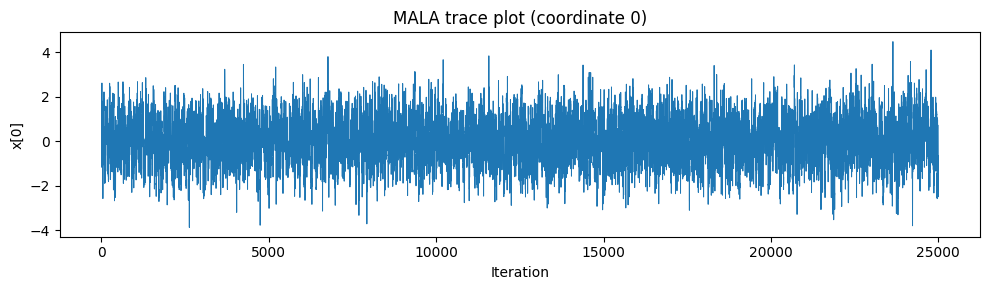

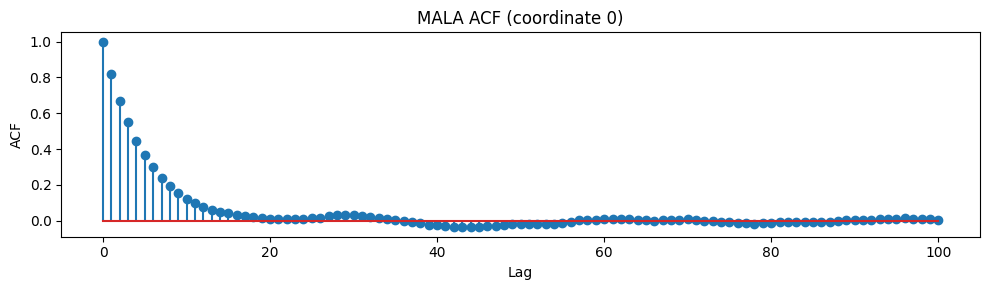

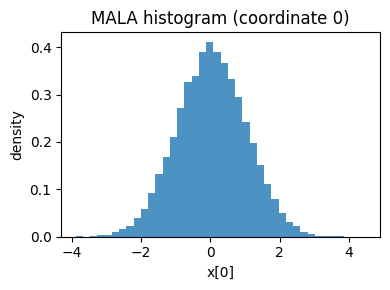

In [ ]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени)

import matplotlib.pyplot as plt

coord = 0
samples = mala_chain_b[:, coord]

# 1) Trace plot
plt.figure(figsize=(10, 3))
plt.plot(samples, linewidth=0.7)
plt.title(f"MALA trace plot (coordinate {coord})")
plt.xlabel("Iteration")
plt.ylabel("x[0]")
plt.tight_layout()
plt.show()

# 2) ACF
def acf_1d(x, max_lag=100):
    x = x - x.mean()
    c = np.correlate(x, x, mode='full')
    c = c[len(c)//2:]
    c /= c[0]
    return c[:max_lag+1]

lags = 100
acf_vals = acf_1d(samples, max_lag=lags)

plt.figure(figsize=(10, 3))
plt.stem(range(lags + 1), acf_vals)
plt.title(f"MALA ACF (coordinate {coord})")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()
plt.show()

# 3) Гистограмма
plt.figure(figsize=(4, 3))
plt.hist(samples, bins=40, density=True, alpha=0.8)
plt.title(f"MALA histogram (coordinate {coord})")
plt.xlabel("x[0]")
plt.ylabel("density")
plt.tight_layout()
plt.show()
